In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

from spatgame import evolve, evolve_old

In [2]:
plt.style.use("seaborn-whitegrid")

In this game $L^2$ individual "*players*" placed in a two-dimensional spatial array.

Every individual can play one of two tactics: cooperate($\mathcal{C}$) or defect($\mathcal{D}$). At the beginning of the "game", each player has the probability of being assigned $\mathcal{C}$ with probability $p_c$ and tactics $\mathcal{D}$ otherwise.

In each round individuals "*play the game*" with 8 its neighbors and the *average cooperator*. Tables of payoffs shown below

Table: Payoffs for games with neighbors.

| payoffs | $\mathcal{D}$ | $\mathcal{C}$ |
| --------- |:-------------:|----:|
| $\mathcal{D}$ | 0 | 0 |
| $\mathcal{C}$ | $b$ | 1 |

Table: Payoffs for games with *average cooperator*

| payoffs | $\mathcal{D}$ | $\mathcal{C}$ |
| --------- |:-------------:|----:|
| $\mathcal{D}$ | 0 | 0 |
| $\mathcal{C}$ | $b f_c$ | $f_c$ |

After playing all games the site occupied either by its original owner or by one of the neighbors who scores the highest total payoff in that round.

In [3]:
Ls = [20, 50, 100, 200]
bs = list(np.linspace(.9, 2, 60))

seeds = [5,58,4785,45895,1256,65478,854,126,42,1458,458,96324,985423,85456, 4585, 8956, 8596589,89589,74,658,84,845,9,55,489, 32,456,345,876,6, 457, 34,67,444,666, 5678, 98, 65, 389, 8765]
p_c = .9 # probability of being assigned strategy C

In [ ]:
for L in Ls:
    for idx, seed in enumerate(seeds):
        np.random.seed(seed)
        np.save("fields/field_{}_{}.npy".format(L, idx), np.random.choice((0, 1), (L, L), p=(1-p_c, p_c)))

<IPython.core.display.Javascript object>


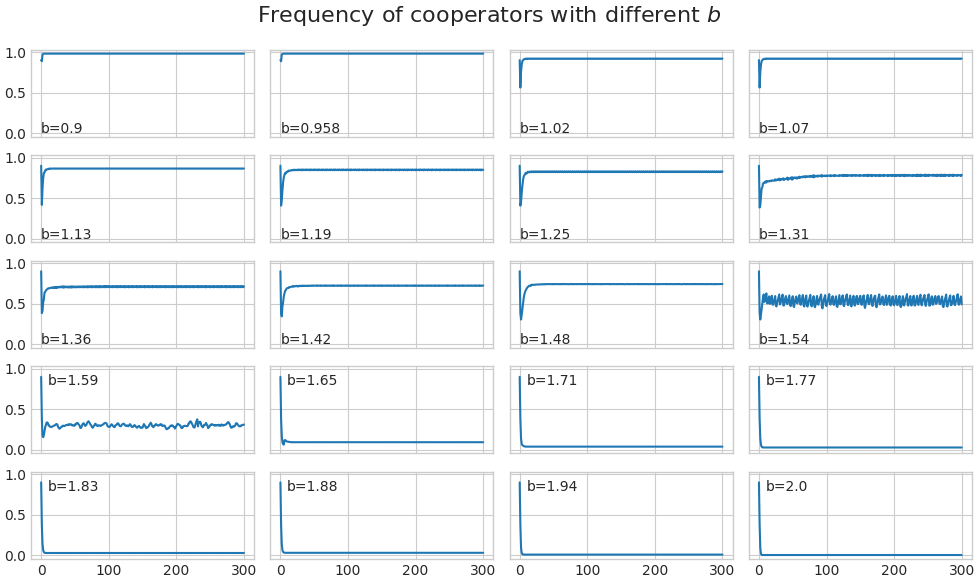

100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


In [6]:
fig, axs = plt.subplots(5, 4, constrained_layout=True, sharex=True, sharey=True)
fig.suptitle('Density of cooperators with different $b$', fontsize=16)
for i, b in tqdm(enumerate(np.linspace(.9, 2, 20)), total=20):
    for n in [29]:
        field = np.load("fields/field_100_{}.npy".format(n))
        d = [field.sum()/(1.*field.shape[0]**2)]
        for _ in range(int(300)):
            field = evolve(field, b, 1)
            d.append(field.sum()/(1.*field.shape[0]**2))
        axs[i//4, i % 4].plot(d)
        if i > 11:
            axs[i//4, i % 4].text(10, 0.8, "b={:.3}".format(b, fontsize=11))
        else:
            axs[i//4, i % 4].text(0, 0, "b={:.3}".format(b, fontsize=11))

plt.show()

In [7]:
fig.savefig("figures/f_c_for_different_b.jpg", dpi=300, quality=95)

<IPython.core.display.Javascript object>


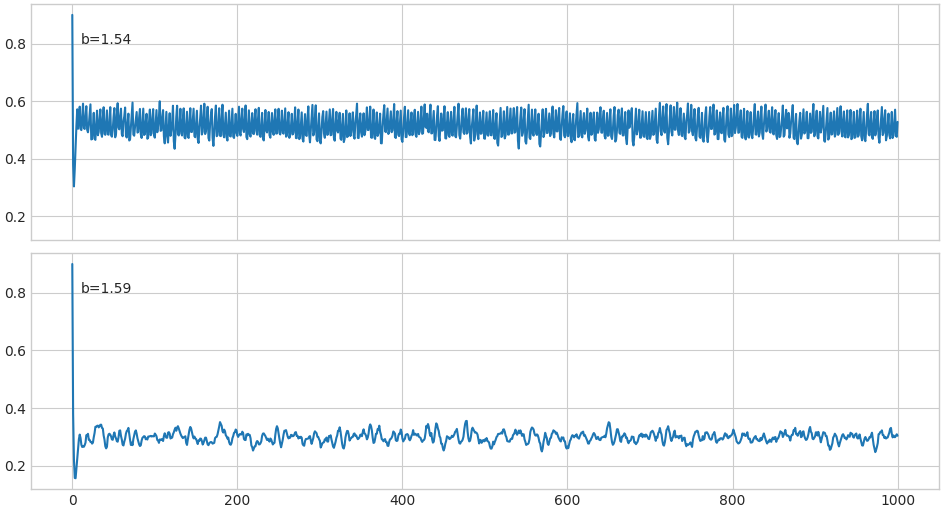

In [13]:
fig, axs = plt.subplots(2, 1, constrained_layout=True, sharex=True, sharey=True)
for i, b in enumerate([1.54, 1.59]):
    for n in [29]:
        field = np.load("fields/field_100_{}.npy".format(n))
        d = [field.sum()/(1.*field.shape[0]**2)]
        for _ in range(int(1000)):
            field = evolve(field, b, 1)
            d.append(field.sum()/(1.*field.shape[0]**2))
        axs[i].plot(d)
        axs[i].text(10, 0.8, "b={:.3}".format(b, fontsize=11))

As shown in figure above density of the cooperators become stable after 100 steps for all $b$ and oscilates with different frequency and amplitude around mean values.

In [4]:
DROP = 500
CALC = 2000
EVERY = 1
L = 100

## Let's collect data...

We will begin from game described in the article "The spatial dilemmas of evolution"

In [5]:
density = []
for b in tqdm(bs):
    den = []
    for i in range(len(seeds)):
        d = []
        field = np.load("fields/field_{}_{}.npy".format(L, i) )
        field = evolve(field, b, DROP)
        for _ in range(0, CALC-DROP, EVERY):
            field = evolve_old(field, b, EVERY)
            d.append(field.sum()/(1.*field.shape[0]*field.shape[1]))
        den.append(d)
    density.append(den)
    
np.save("data/density_of_cooperators_old_game.npy", np.asarray(density))

100%|██████████| 60/60 [3:26:37<00:00, 372.85s/it]  


And moves to the game that was described above

In [6]:
density = []
for b in tqdm(bs):
    den = []
    for i in range(len(seeds)):
        d = []
        field = np.load("fields/field_{}_{}.npy".format(L, i) )
        field = evolve(field, b, DROP)
        for _ in range(0, CALC-DROP, EVERY):
            field = evolve(field, b, EVERY)
            d.append(field.sum()/(1.*field.shape[0]*field.shape[1]))
        den.append(d)
    density.append(den)
    
np.save("data/density_of_cooperators.npy", np.asarray(density))

100%|██████████| 60/60 [3:29:53<00:00, 193.33s/it]  


## then cook and serve it

In [5]:
density_old_raw = np.load("data/density_of_cooperators_old_game.npy")
density_new_raw = np.load("data/density_of_cooperators.npy")

density_old = density_old_raw.mean(axis=-1)
density_new = density_new_raw.mean(axis=-1)

# density_old = density_old_raw.reshape((60, -1))
# density_new = density_new_raw.reshape((60, -1))

std_o = density_old.std(axis=-1)
std_n = density_new.std(axis=-1)

means_o = density_old.mean(axis=-1)
means_n = density_new.mean(axis=-1)

## Transition values

The game is defined by the payoff $b$ and different behaviour is expected at different $b$

To find the values of $b$ at which transition occurs we have to understand at which values the total outcome of agent may change.


<img src="./configurations.jpg" alt="drawing" width="300"/>

By looking at picti=ure above we can come up with this formuls for $b$
$$b=\frac{n_{c\;shared}+n_c+f_c}{n_{c\;shared}+n_d+f_c+1}$$
for left side configurations

$$b=\frac{n_{c\;shared}+n_c+f_c}{n_{c\;shared}+n_d+f_c}$$
for right side configurations

Where

$n_{c\;shared}$ - number of cooperators($\mathcal{C}$) from red region

$n_c$ - number of cooperators near cooperator(purple region)

$n_d$ - number of cooperators near defector(yellow region)

$f_c$ - density of cooperators

In [6]:
def with_agents(f_c, n_share, n_c, n_d):
    return (n_share+n_c+f_c)/(n_share+n_d+f_c+1)

def without_agents(f_c, n_share, n_c, n_d):
    return (n_share+n_c+f_c)/(n_share+n_d+f_c)

In [7]:
f_cs = np.linspace(0, 1, 20)

In [8]:
all_transitions = []
for n_allowed in [[1, 2, 3], [1, 2, 3, 4, 5]]:
    for n_share in range(7-len(n_allowed)):
        for n_c in n_allowed:
            for n_d in n_allowed:
                all_transitions.append(with_agents(f_cs, n_share, n_c, n_d))
                
for n_allowed in [[1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7]]:
    for n_share in range(8-len(n_allowed)):
        for n_c in n_allowed:
            for n_d in n_allowed:
                all_transitions.append(without_agents(f_cs, n_share, n_c, n_d))

In [9]:
transitions = []
for i, tr in enumerate(all_transitions[:-1]):
    if not (np.square(np.array(all_transitions[i+1:]) - tr).sum(-1) < 0.0000001).any():
        transitions.append(tr)
transitions.append(all_transitions[-1])

Values of transitions for the game with itself were taken from the article "The spatial dilemmas of evolution" by A. Novak and M. May, 1993

## Let's see what we got

<IPython.core.display.Javascript object>


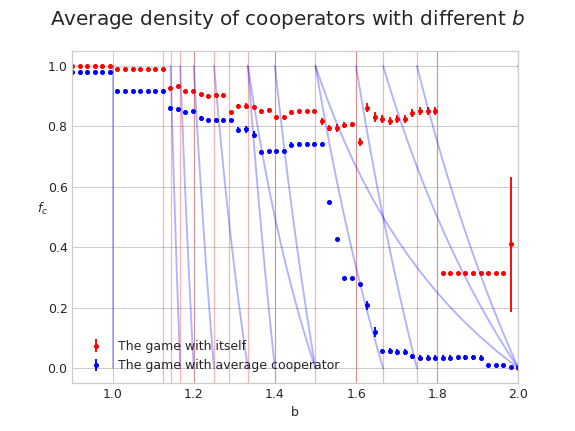

Text(0, 0.5, '$f_c$')

In [12]:
fig = plt.figure()
plt.xlim(.9, 2)
plt.suptitle('Average density of cooperators with different $b$', fontsize=16)
plt.errorbar(bs, means_o, yerr=std_o, fmt=".r", label="The game with itself")
plt.errorbar(bs, means_n, yerr=std_n, fmt=".b", label="The game with average cooperator")
plt.legend(loc="lower left")
plt.xlabel("b")

for x in [9/8, 8/7, 7/6, 6/5, 5/4, 9/7, 8/6, 7/5, 6/4, 8/5, 5/3, 7/4, 9/5, 2]:
    plt.axvline(x=x, linewidth=1, color='r', alpha=.3, label="For game with itself")

for x in transitions:
    plt.plot(x, f_cs, '-b', alpha=.3) #, label="For game with average")
plt.ylabel("$f_c$", rotation=0)

In [13]:
plt.savefig("figures/cooperators_density_at_different_b", dpi=300, quality=95)